# Introduction to Web Scraping
Data Science Kitchen  
May 4, 2023  
Zhaosen Guo

# Overview







As we start our journey into data science, machining learning, and analytics, the first thing we need to do is **get the data**! There might be avalible dataset that we can simply download, but as we begin to formulate our own research questions and expand our needs to particular collections of data, we would need to start getting out own data. 

This notebook gives us a series of examples for:


* Acquiring data from online sources
* HTML structure
* Information extraction from webpages
  * HTTP requests 
  * Automated browsers


## Preperation


In [2]:
#@title Run the collapsed code cell below to install nessesary packages and enable Selenium working in Colab
%%capture

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

!apt-get update
!apt-get install chromium chromium-driver
!pip3 install selenium

CalledProcessError: ignored

# Part 1: Aquiring Data

## Locally import

Our most straight forward option is to download the data file to our local environment, then import it. Here we will read a CSV file from the sample folder in the colab env and show it.

In [3]:
import pandas as pd
sample_data_mnist = pd.read_csv('/content/sample_data/mnist_train_small.csv')
sample_data_mnist.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## HTTP Request



Alternatively, we can submit a HTTP request for an online file.  
Packages to consider:


*   `urllib` - in Python standard library and provides basic functionality for making HTTP requests 
*   `requests` - 3ed party library for advanced use, provides a user-friendly API. 
*   `urllib3` - 3rd party library for advanced use, a good choice if you need thread features like connection pooling or SSL/TLS support. 

This is a data file that is available online: 
https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv


Let's use each of the mentioned methods to grab it. 
Starting off with `urllib`:

In [4]:
url = 'https://gist.githubusercontent.com/jvilledieu/728f43c7adb88352f36831fe0c173544/raw/202042b847a7aa0e886ba4d64697ab1e51faf5dc/entity_map.csv'

In [5]:
import urllib

data = urllib.request.urlopen(url)

random_df = pd.read_csv(data)
random_df.head(5)

,RES_ENT_ID,DATA_SOURCE,RECORD_ID
0,1,CUSTOMERS,1001
1,1,REFERENCE,1001
2,1,WATCHLIST,1001
3,1,CUSTOMERS,1002
4,1,REFERENCE,1002


Now, using `requests`:

In [6]:
import requests
import io

response = requests.get(url)
data = response.content.decode('utf-8')

df = pd.read_csv(io.StringIO(data))

df.head(5)

,RES_ENT_ID,DATA_SOURCE,RECORD_ID
0,1,CUSTOMERS,1001
1,1,REFERENCE,1001
2,1,WATCHLIST,1001
3,1,CUSTOMERS,1002
4,1,REFERENCE,1002


And lastly, with `urllib3`:

In [7]:
import urllib3

http = urllib3.PoolManager()
response = http.request('GET', url)

data = response.data.decode('utf-8')

df = pd.read_csv(io.StringIO(data))
df.head(5)

,RES_ENT_ID,DATA_SOURCE,RECORD_ID
0,1,CUSTOMERS,1001
1,1,REFERENCE,1001
2,1,WATCHLIST,1001
3,1,CUSTOMERS,1002
4,1,REFERENCE,1002


All the resulting dataframe are the same, and actually, now `pandas` offers direct read-in of data, so save those packages for more complexed files, such as zip or html:

In [8]:
df = pd.read_csv(url)
df.head(5)

,RES_ENT_ID,DATA_SOURCE,RECORD_ID
0,1,CUSTOMERS,1001
1,1,REFERENCE,1001
2,1,WATCHLIST,1001
3,1,CUSTOMERS,1002
4,1,REFERENCE,1002


But what if there's not a file we can download or import? How should we "grab" things directly from the webpages? 

# Part 2: HTML


HTML (Hypertext Markup Language) is the standard language used to create web pages. It consists of a series of tags and attributes that define the structure and content of a web page.


## HTML Tags


HTML tags are used to define different types of content on a web page. Tags are enclosed in angle brackets, and can contain attributes that modify their behavior. Here are some examples of common HTML tags:

- `<html>`: Defines the beginning and end of an HTML document.
- `<head>`: Contains information about the document, such as the page title and links to external resources.
- `<body>`: Contains the main content of the document.
- `<h1>` to `<h6>`: Defines headings of different sizes.
- `<p>`: Defines a paragraph of text.
- `<a>`: Defines a hyperlink to another web page or resource.
- `<table>`: Defines a table of data.
- `<tr>`: Defines a row in a table.
- `<th>`: Defines a header cell in a table.
- `<td>`: Defines a data cell in a table.

## HTML Attributes


HTML attributes are used to modify the behavior of HTML tags. Attributes are specified within the opening tag of a tag, and are written as name-value pairs. Here are some examples of common HTML attributes:

- `id`: Specifies a unique identifier for an HTML element.
- `class`: Specifies one or more classes for an HTML element. Classes are used to apply styles and behaviors to groups of elements.
- `href`: Specifies the URL of a hyperlink.
- `src`: Specifies the URL of an image or other resource.
- `style`: Specifies CSS styles to apply to an element.
- `colspan`: Specifies the number of columns a header or data cell should span in a table.
- `rowspan`: Specifies the number of rows a header or data cell should span in a table.


## Example


Here's an example of a simple HTML document that includes a table with class attributes:


```html
<!DOCTYPE html>
<html>
  <head>
    <title>My Page</title>
  </head>
  <body>
    <h1>Welcome to my page</h1>
    <p>This is some text on my page.</p>
    <table class="my-table">
      <tbody>
      <tr>
        <th>Column 1</th>
        <th>Column 2</th>
      </tr>
      <tr>
        <td>Row 1, Column 1</td>
        <td>Row 1, Column 2</td>
      </tr>
      <tr>
        <td>Row 2, Column 1</td>
        <td>Row 2, Column 2</td>
      </tr>
            </tbody>

    </table>
    <a href="https://www.example.com">Click here</a> for the source of my table.

  </body>
</html>```



In this example, the `<!DOCTYPE html>` declaration specifies that the document uses the HTML5 standard. The `<html>` tag defines the beginning and end of the HTML document. The `<head>` tag contains information about the document, such as the title, which appears in the browser's title bar. The `<body>` tag contains the main content of the document, including a heading `<h1>` and a paragraph `<p>`. The `<a>` tag defines a hyperlink to another web page, and uses the href attribute to specify the URL of the linked page. The `<table>` tag defines a table of data, and uses the class attribute to specify the CSS class "my-table". The `<tr>` tag defines a row in the table, and contains `<th>` and `<td>` tags to define header and data cells, respectively.

## Inspect Webpages
([wiki page](https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area))

Now it is important to locate the elements you need from a page, and your right click and "Inspect" can help with that. 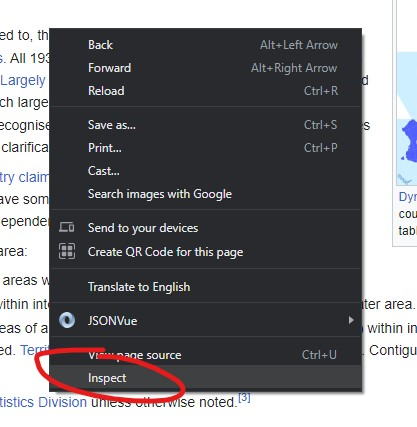

This will open up a side panel where you can see all the HTML elements, sort them, search, copy paths, and perform other actions.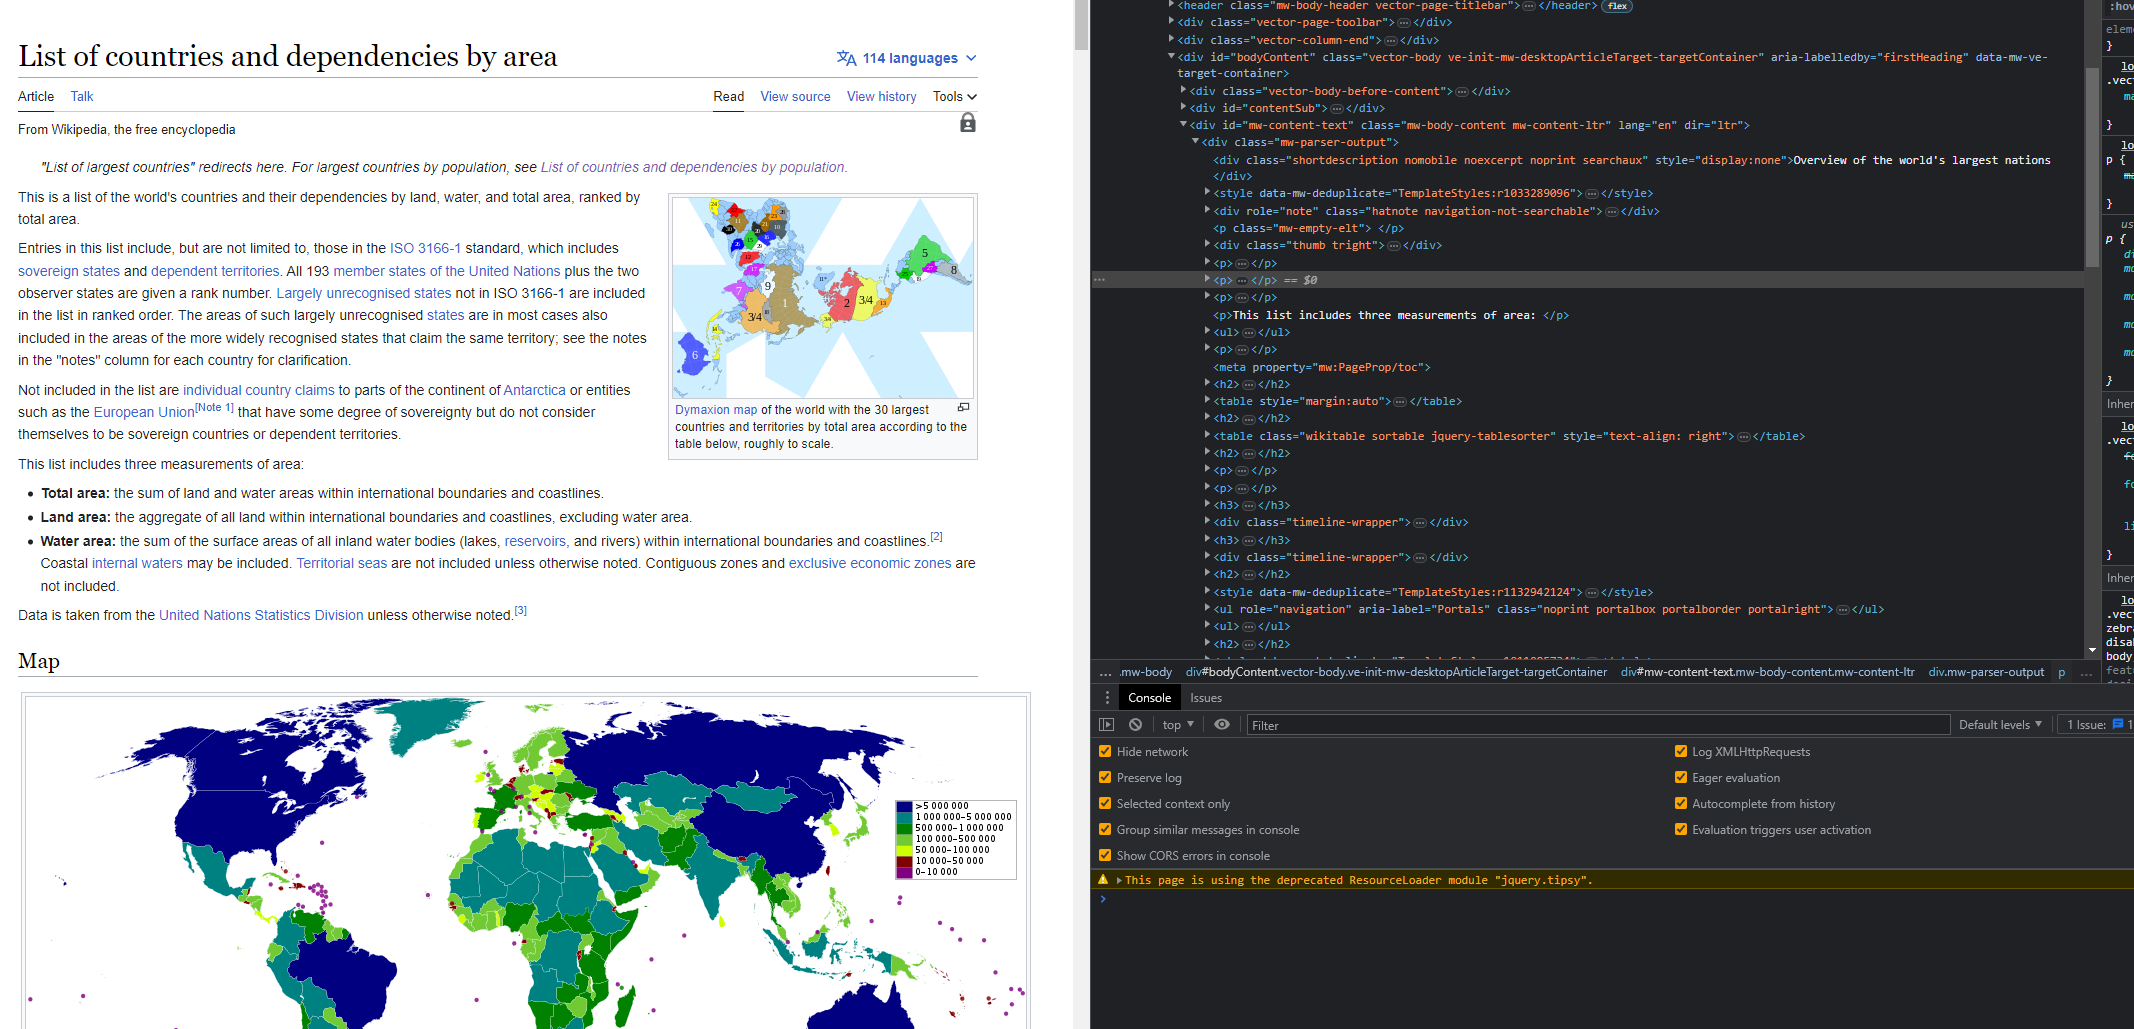

# Part 3: Info Extraction

Now that we have a webpage that we would like to extract information, do we just start right away? Probably not! 

## Best Practices


- Follow website terms of service and robots.txt file
  - Respect the site's structure and hierarchy
  - e.g. https://finance.yahoo.com/robots.txt, https://www.sec.gov/robots.txt
- Limit requests to avoid overwhelming the server
  - `time.sleep(1)`
- Validate the data for accuracy and completeness
- Be ethical and respect the website owner's rights


## Approach A: HTTP requests 

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Fetch the Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'
response = requests.get(url)

# Parse the HTML content using Beautiful Soup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table of interest by its class name
table = soup.find('table', {'class': 'wikitable sortable'})

# Convert the table into a Pandas DataFrame
df = pd.read_html(str(table))[0]

# Print the first few rows of the DataFrame
df.head(10)


,Rank,Country / Dependency,Total in km2 (mi2),Land in km2 (mi2),Water in km2 (mi2),% water,Notes
0,NaN,World,"510,072,000 (196,940,000)","148,940,000 (57,510,000)","361,132,000 (139,434,000)",70.8,NaN
1,1,Russia,"17,098,246 (6,601,670)","16,378,410 (6,323,740)","719,836 (277,930)",4.2,[Note 2]
2,NaN,Antarctica,"14,200,000 (5,500,000)","14,200,000 (5,500,000)",0 (0),0,[Note 3]
3,2,Canada,"9,984,670 (3,855,100)","9,093,507 (3,511,023)","891,163 (344,080)",8.9,[Note 4]
4,3 or 4 [Note 5],China,"9,596,961 (3,705,407)","9,326,410 (3,600,950)","270,550 (104,460)",2.8,[Note 6][7]
5,3 or 4 [Note 5],United States,"9,833,517 (3,796,742)","9,147,593 (3,531,905)","685,924 (264,837)",7.0,[Note 7]
6,5,Brazil,"8,515,767 (3,287,956)","8,460,415 (3,266,584)","55,352 (21,372)",0.6,[Note 8]
7,6,Australia,"7,692,024 (2,969,907)","7,633,565 (2,947,336)","58,459 (22,571)",0.8,[Note 9]
8,7,India,"3,287,263 (1,269,219)","2,973,190 (1,147,960)","314,073 (121,264)",9.6,[Note 10]
9,8,Argentina,"2,780,400 (1,073,500)","2,736,690 (1,056,640)","43,710 (16,880)",1.6,[Note 11]


Sometimes you may get an error message or number such as 404 when trying to get to a website - I recommend checking for the error message at https://http.cat/. 

## Approach B: Automated Browser 

Automated Browser Demo -   
On Colab we cannot have another pop up, but usually if you run `selenium` it would pop up a window as if someone is actually controlling a browser.

### Looking through row by row with additional idenfifiers 

Highlights:  
- `driver.get()`  
- `find_element()` vs. `find_elements()`
- `By.CLASS_NAME`, `By.TAG_NAME`, `By.XPATH`
- `driver.quit()`


In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By


# Setting up the driver
service = Service("/usr/bin/chromedriver")

options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=service, options=options)

# navigate to the webpage
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'
driver.get(url)

# find the table element by its class
table = driver.find_element(By.CLASS_NAME, 'wikitable')

# create an empty list to store the table data
data = []

# iterate over the rows in the table
for row in table.find_elements(By.TAG_NAME, 'tr'):
    # create an empty list to store the row data
    row_data = []
    
    # iterate over the cells in the row
    for cell in row.find_elements(By.TAG_NAME, 'td'):
        # append the text in each cell to the row data
        row_data.append(cell.text)
    
    # append the row data to the table data
    data.append(row_data)

# create a Pandas DataFrame from the table data
column_names = ['Rank', 'Country', 'Total Area', 'Land Area', 'Water Area', ' % Water', 'Notes']
df = pd.DataFrame(data[1:], columns=column_names)

# close the webdriver
driver.quit()

df.head()

,Rank,Country,Total Area,Land Area,Water Area,% Water,Notes
0,–,World,"510,072,000 (196,940,000)","148,940,000 (57,510,000)","361,132,000 (139,434,000)",70.8,
1,1,Russia,"17,098,246 (6,601,670)","16,378,410 (6,323,740)","719,836 (277,930)",4.2,[Note 2]
2,–,Antarctica,"14,200,000 (5,500,000)","14,200,000 (5,500,000)",0 (0),0,[Note 3]
3,2,Canada,"9,984,670 (3,855,100)","9,093,507 (3,511,023)","891,163 (344,080)",8.9,[Note 4]
4,3 or 4\n[Note 5],China,"9,596,961 (3,705,407)","9,326,410 (3,600,950)","270,550 (104,460)",2.8,[Note 6][7]


### Clicking to New Pages 
`<element>.click()`

In [12]:
# re-initialize diver
driver = webdriver.Chrome(service=service, options=options)

# navigate to the webpage
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'
driver.get(url)

# find the link to the "List of sovereign states" page
link = driver.find_element(By.LINK_TEXT, 'List of sovereign states')

# click the link
link.click()

# print the first link of an image class
image = driver.find_element(By.CLASS_NAME, 'image')
print(image.get_attribute('href'))

# close the webdriver
driver.quit()

https://en.wikipedia.org/wiki/File:Palais_des_Nations_unies,_%C3%A0_Gen%C3%A8ve.jpg
